# <font color="blue">1. Import Libraries</font>

* Import the required libraries.

In [1]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tqdm.notebook import tqdm
from sklearn.metrics import log_loss, confusion_matrix, f1_score, roc_curve, auc, balanced_accuracy_score, matthews_corrcoef
from custom_package.response_encoder import ResponseEncoder as responseEncoder
from custom_package.standardize import Standardize as standardize

In [2]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

# <font color="blue">2. Utility Function - Merge Dataset</font>

In [3]:
def combineDatasets(dataProvider, dataBeneficiary, dataInpatient, dataOutpatient):
        
    '''
    Combines the given datasets of Provider data, Beneficiary data, Inpatient and Outpatient claims data,
    and returns the combined dataset.

    Parameters:
    ----------
    dataProvider: pandas.core.frame.DataFrame
        DataFrame containing the Provider Unique Identifier.
    dataBeneficiary: pandas.core.frame.DataFrame
        DataFrame containing the Beneficiary related data.
    dataInpatient: pandas.core.frame.DataFrame
        DataFrame containing the Inpatient claims related data.
    dataOutpatient: pandas.core.frame.DataFrame
        DataFrame containing the Outpatient claims related data       
    '''

    # Concatenate the Inpatient and Outpatient dataset as these contain almost similar information
    dataConcat = pd.concat([dataInpatient, dataOutpatient])

    # Merge the above dataframe with the Beneficiary dataframe
    dataMerge = pd.merge(left=dataConcat, right=dataBeneficiary, on='BeneID')

    # Merge the above dataframe with the provider dataframe to add the Class Label.
    dataFinal = pd.merge(left=dataMerge, right=dataProvider, on='Provider')

    # Return the final dataframe
    return dataFinal

# <font color="blue">3. Function 1</font>

* Function to predict the class label as fraudulent or non-fraudulent.

In [4]:
def function1(xData, predict=True):
    '''
    Function to implement the data pipeline for transforming the dataset into the required format as required by the
    Model and predict whether the given claim record(s) is/are fraudulent or not.
    
    Parameters:
    ----------
    xData: DataFrame
        Dataset containing the features.
    predict: bool
        Boolean flag to decide whether to just apply the pipeline without doing prediction (in case of False value )or
        apply the pipeline followed by prediction (in case of True value)
    '''
    
    # Create a copy of the dataset
    data = xData.copy()
    
    #region - Data Cleanup-------------------------------------------------------------------------------------------
    #================================================================================================================
    
    def dataCleanup(data):
        '''
        Cleans up the data in the given dataset and returns the cleaned dataset.

        Parameter:
        ---------
        data: pandas.core.frame.DataFrame
            Dataframe to be cleaned up
        '''

        #region - Beneficiary Columns-------------------------------------------------------------------------------

        # 'Renal Disease Indicator' column.
        # RenalDiseaseIndicator column has two unique values: 0 and 'Y'. Replace the value of 'Y' with 1.
        data['RenalDiseaseIndicator'].replace(to_replace='Y', value=1, inplace=True)
        
        # Convert the datatype of the 'RenalDiseaseIndicator' feature to numeric.
        data['RenalDiseaseIndicator'] = data['RenalDiseaseIndicator'].apply(pd.to_numeric)

        # 'Chronic Condition' columns
        # 'ChronicCond_' columns contains two unique values: 1 and 2. Replace the value of 2 with 0 to indicate 1 as 'Yes' 
        # and 0 as 'No'
        for chronicCol in [col for col in list(data.columns) if 'Chronic' in col]:
            data[chronicCol].replace(to_replace=2, value=0, inplace=True)

        # Rename the column 'County' as 'Country'
        data.rename(columns={'County': 'Country'}, inplace=True)    

        #endregion - Beneficiary Columns----------------------------------------------------------------------------


        #region - Inpatient and Outpatient Columns------------------------------------------------------------------

        # Fill empty values of the 'DeductibleAmtPaid' feature as it is a numeric feature and has some empty values.
        data['DeductibleAmtPaid'].fillna(value=0, inplace=True)

        #region - Inpatient and Outpatient Columns------------------------------------------------------------------


        #region - Other columns ------------------------------------------------------------------------------------

        # Drop the columns having all null values
        data.dropna(axis=1, how='all', inplace=True)

        # Replace the class label 'PotentialFraud' values. Replace 'Yes' with 1 and 'No' with 0.
        if ('PotentialFraud' in data.columns):

            data['PotentialFraud'].replace(to_replace=['Yes', 'No'], value=[1, 0], inplace=True)

        #endregion - Other columns ---------------------------------------------------------------------------------
        
    # Call the function 'dataCleanup' to clean the data in the dataframe
    dataCleanup(data)
        
    # Set of columns to be removed
    columnsToRemove = ['ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5']
    
    # Remove the above set of columns from the dataframe.
    data.drop(columns=columnsToRemove, inplace=True)
    
    #endregion - Data Cleanup----------------------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - Date Features------------------------------------------------------------------------------------------
    #================================================================================================================
    
    # Date related columns
    colDate = [col for col in data.columns if ('Dt' in col or 'DOB' in col or 'DOD' in col)]
    
    # Convert these columns to DateTime Format
    data[colDate] = data[colDate].apply(pd.to_datetime)
    
    # Generate new Feature 'ClaimSettlementDelay' (ClaimEndDt - ClaimStartDt)
    data['ClaimSettlementDelay'] = (data['ClaimEndDt'] - data['ClaimStartDt']).dt.days
    
    # Generate new Feature 'TreatmentDuration' (DischargeDt - AdmissionDt)
    data['TreatmentDuration'] = (data['DischargeDt'] - data['AdmissionDt']).dt.days
    data['TreatmentDuration'].fillna(0, inplace=True) # Filling empty values with 0 because the features 
    # 'DischargeDt' and 'AdmissionDt' exist only for Inpatient records.

    data['TreatmentDuration'] = data['TreatmentDuration'].apply(int)
    
    maxDate = max(data['ClaimEndDt'].max(), data['DischargeDt'].max())
    
    # Generate 'Age' feature from DOB based on the DOD or the maximum date.
    data['Age'] = data.apply(lambda x: round(((x['DOD'] - x['DOB']).days)/365) if pd.notnull(x['DOD'])
                             else round(((maxDate - x['DOB']).days)/365), axis=1)
    
    # Generate new Feature 'IsDead' based on whether there is a value in the DOD column or not
    data['IsDead'] = data['DOD'].apply(lambda x: 1 if pd.notnull(x) else 0)
    
    # Remove the set of date columns from the dataframe
    data.drop(columns=colDate, inplace=True)
    
    #endregion - Date Features---------------------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - Amount Features----------------------------------------------------------------------------------------
    #================================================================================================================
    
    # Fetch the features related to amount.
    colAmt = [col for col in data.columns if 'Amt' in col]
    
    # Total Claim Amount = Insurance Claim Amount reimbursed + Deductible Amount paid by the Subscriber
    data['TotalClaimAmount'] = data['InscClaimAmtReimbursed'] + data['DeductibleAmtPaid']

    # Total Inpatient Amount = Inpatient Annual Amount reimbursed + Inpatient Annual Deductible Amount
    data['IPTotalAmount'] = data['IPAnnualReimbursementAmt'] + data['IPAnnualDeductibleAmt']

    # Total Outpatient Amount = Outpatient Annual Amount reimbursed + Outpatient Annual Deductible Amount
    data['OPTotalAmount'] = data['OPAnnualReimbursementAmt'] + data['OPAnnualDeductibleAmt']
    
    # Remove the set of old amount features from the dataframe
    data.drop(columns=colAmt, inplace=True)
    
    #endregion - Amount Features-------------------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    # Fetch the Claim Id and Provider Id from the dataset
    identifierData = data[['ClaimID', 'Provider']]
    
    # Drop some of the unique identifiers from the dataset as they won't contribute anything to do the classification.
    data.drop(columns=['ClaimID', 'BeneID', 'Provider', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], inplace=True)
    
    
    
    #region - Physician Features-------------------------------------------------------------------------------------
    #================================================================================================================
    
    # Fetch the columns related to Physicians
    colPhys = [col for col in data.columns if 'Physician' in col]
    
    # Prepare the feature 'UniquePhysCount'
    data['UniquePhysCount'] = data[colPhys].apply(lambda x: len(set([phys for phys in x if not pd.isnull(phys)])), axis=1)
    
    # Prepare the feature 'PhysRoleCount'
    data['PhysRoleCount'] = data[colPhys].apply(lambda x: len([phys for phys in x if not pd.isnull(phys)]), axis=1)
    
    # Prepare the feature 'IsSamePhysMultiRole1'
    data['IsSamePhysMultiRole1'] = data[['UniquePhysCount','PhysRoleCount']] \
                                .apply(lambda x: 1 if x['UniquePhysCount'] == 1 and x['PhysRoleCount'] > 1 else 0, axis=1)
    
    # Prepare the feature 'IsSamePhysMultiRole2'
    data['IsSamePhysMultiRole2'] = data[['UniquePhysCount','PhysRoleCount']] \
                                .apply(lambda x: 1 if x['UniquePhysCount'] == 2 and x['PhysRoleCount'] > 2 else 0, axis=1)
    
    def encodeCatFeatures(dataset, existingFeatures, newFeatures, suffix=''):
        '''
        Function to create new encoded features for Categorical Features, based on their count of values 
        in the existing set of features.

        Parameters:
        ----------
        dataset: pandas.core.frame.DataFrame
            DataFrame containing the data for which the new set of encoded features has to be created.
        exsitingFeatures: list
            List of existing features to considered for counting.
        newFeatures: list
            List of new features to encoded and created
        suffix: str
            Suffix to add before the new feature names.
        '''

        # Fetch the number of datapoints in the given dataset
        lenDatapoints = dataset.shape[0]

        # Iterate through each of the new features:
        for newFeature in newFeatures:

            listIsExistAllFeatures = list() # List to store a list of 0s and 1s for each existing feature,
            # if the new feature value exist in the existing features.

            # Iterate through each of the existing feature set and perform the logic to count.
            for existingFeature in existingFeatures:

                listIsExist = list() # List to store '1' if the new feature value exist in the existing feature.

                for value in list(dataset[existingFeature]):

                    if str(value) == str(newFeature):

                        listIsExist.append(1)

                    else:

                        listIsExist.append(0)

                listIsExistAllFeatures.append(listIsExist)

            arrayCount = np.zeros(lenDatapoints) # Array to store the count of the existing features containing the new features.

            # Iterate through each of the list in 'listIsExistAllFeatures' and sum the counts.
            for i in range(0, len(listIsExistAllFeatures)):

                arrayCount = arrayCount + np.array(listIsExistAllFeatures[i])

            dataset[suffix + newFeature] = arrayCount.astype(int)

        return dataset
    
    # Call the encodedFeatures function to generate new features: 'PHY412132', 'PHY337425', 'PHY330576'
    data = encodeCatFeatures(data, colPhys, ['PHY412132', 'PHY337425', 'PHY330576'])
    
    # Now remove the original features related to the Physicians
    data.drop(columns=['AttendingPhysician','OperatingPhysician','OtherPhysician'], inplace=True)
    
    #endregion - Physician Features----------------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - Claim Diagnosis Features-------------------------------------------------------------------------------
    #================================================================================================================
    
    # Fetch the columns related to the Claims Diagnosis Codes
    colDiagCode = [col for col in data.columns if 'ClmDiagnosisCode' in col]
    
    # Call the encodeCatFeatures function to generate new feature for the top 7 Claim Diagnosis Codes
    data = encodeCatFeatures(data, colDiagCode, ['4019', '2724', '42731', '25000', '2449', '53081', '4280'], 'ClmDiagCode_')
    
    # For each of the Claim Diagnosis Code Features, replace the values with 1 if there is a value, else replace with 0 .
    for diagCode in colDiagCode:
        data[diagCode] = data[diagCode].apply(lambda x: 1 if not pd.isnull(x) else 0)
    
    #endregion - Claim Diagnosis Features----------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - Claim Procedure Features-------------------------------------------------------------------------------
    #================================================================================================================
    
    # Fetch the columns related to the Claims Procedure Codes
    colProcCode = [col for col in data.columns if 'Procedure' in col]
    
    # Call the encodeCatFeatures function to generate new feature for the top 5 Claim Procedure Codes
    data = encodeCatFeatures(data, colProcCode, ['9904.0', '8154.0', '66.0', '3893.0', '3995.0'], 'ClmProcCode_')
    
    # For each of the Claim Procedure Code Features, replace the values with 1 if there is a value, else replace with 0 .
    for procCode in colProcCode:
        data[procCode] = data[procCode].apply(lambda x: 1 if not pd.isnull(x) else 0)
    
    #endregion - Claim Procedure Features----------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - Claim Admit Diagnosis Code and Diagnosis Group Code Features-------------------------------------------
    #================================================================================================================
    
    # For each of the Claim Admit Diagnosis Code and Diagnosis Group Code Features, 
    # replace the values with 1 if there is a value, else replace with 0 .
    for code in ['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode']:
        data[code] = data[code].apply(lambda x: 1 if not pd.isnull(x) else 0)
    
    #endregion - Claim Admit Diagnosis Code and Diagnosis Group Code Features----------------------------------------
    #================================================================================================================
    
    
    
    #region - Gender Feature-----------------------------------------------------------------------------------------
    #================================================================================================================
    
    # Gender Feature has two values: 1 and 2. Replace 2 with 0.
    data['Gender'].replace(to_replace=2, value=0, inplace=True)
    
    #endregion - Gender Feature--------------------------------------------------------------------------------------
    #================================================================================================================
    
    # Remove some set of Claim Diagnosis/Procedure Code Features
    data.drop(columns=['DiagnosisGroupCode', 'ClmProcedureCode_1', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8'], 
              inplace=True)
    
    # If input flag 'Predict' is True, then do the prediction as well. Otherwise, simple return the transformed data
    # from the pipeline.
    if predict==True:
    
        # Reference: 'How to load sklearn pipeline model' - 
        # https://stackoverflow.com/questions/57888291/how-to-properly-pickle-sklearn-pipeline-when-using-custom-transformer/61920454#61920454
        # Load the Model
        with open('Model/BestModel.pkl', 'rb') as f:
            model = pickle.load(f)

        # Predict the Class Label of the input dataset
        yPred = model.predict(data)

        # Prepare a DataFrame with Claim ID and the Class Label indicating Fraud as 1 and non-fraud as 0.
        dfResult = pd.DataFrame({'ClaimID': identifierData['ClaimID'], 'PotentialFraud': yPred})

        # Replace the Class Label '0' with 'No' and '1' with 'Yes'
        dfResult['PotentialFraud'].replace(to_replace=[0, 1], value=['No', 'Yes'], inplace=True)
    
    else:
        
        dfResult = data
    
    return dfResult

In [5]:
# Dictionary containing the keys as the dataset name and its corresponding value containing the location of the dataset.
dataset1Loc = {
    'Provider': 'Data/Test-1542969243754.csv',
    'Beneficiary': 'Data/Test_Beneficiarydata-1542969243754.csv',
    'Inpatient': 'Data/Test_Inpatientdata-1542969243754.csv',
    'Outpatient': 'Data/Test_Outpatientdata-1542969243754.csv'
}

In [6]:
%%time
# Read the Provider data, Beneficiary data, Inpatient and Outpatient claims data from the respective locations.
dataProviderTest = pd.read_csv(dataset1Loc['Provider'])
dataBeneficiaryTest = pd.read_csv(dataset1Loc['Beneficiary'])
dataInpatientTest = pd.read_csv(dataset1Loc['Inpatient'])
dataOutpatientTest = pd.read_csv(dataset1Loc['Outpatient'])

# Call the function 'combineDatasets' to merge the datasets.
xTest = combineDatasets(dataProviderTest, dataBeneficiaryTest, dataInpatientTest, dataOutpatientTest)

Wall time: 1.35 s


In [7]:
%%time
# Call the function1 to know the predictions for the input dataset.
predData = function1(xTest)

Wall time: 45.7 s


In [8]:
# Display the top 10 predictions
print('Number of datapoints of the Test Dataset: ', len(predData))
predData.head(10)

Number of datapoints of the Test Dataset:  135392


,ClaimID,PotentialFraud
0,CLM67387,No
1,CLM56697,Yes
2,CLM63574,No
3,CLM59473,Yes
4,CLM54585,Yes
5,CLM41887,No
6,CLM48054,Yes
7,CLM50294,Yes
8,CLM62092,Yes
9,CLM60653,Yes


----

# <font color="blue">4. Function 2</font>

* Function to calculate the performance metrics and show the values.

In [9]:
def function2(X, y):
    '''
    Function to implement the data pipeline for transforming the dataset into the required format as required by the
    Model and predict whether the given claim record(s) is/are fraudulent or not.
    
    Parameters:
    ----------
    X: DataFrame
        Dataset containing the Features.
    y: Series
        Dataset containng only the Class Labels.
    '''
    
    # Create a copy of the data
    xData = X.copy()
    
    # Call the function1 to implement the data pipeline and get the transformed data
    xData = function1(xData, predict=False)
    
    #region - Log-loss-----------------------------------------------------------------------------------------------
    #================================================================================================================
    
    def getLogloss(yActual, yPredProb):
        '''
        Finds and displays the Log Loss

        Parameters:
        ----------
        yActual: array-like
            Ground truth (correct) class labels for 'n' samples.
        yPredProb: array-like
            Predicted probabilities, as returned by a model's predict_proba method.
        '''

        logloss = log_loss(y_true=yActual, y_pred=yPredProb)

        print('Log-loss of the Model: ', logloss)
        
    #endregion - Log-loss--------------------------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - Performance Matrix-------------------------------------------------------------------------------------
    #================================================================================================================
    
    def plotPerformanceMatrix(yActual, yPred):
        '''
        Function to compute Confusion, Precision and Recall Matrix and plot them.

        Parameters:
        ----------
        yActual: array-like
            Ground truth (correct) class labels for 'n' samples.
        yPred: array-like
            Predicted class labels for 'n' samples.
        '''

        # Get Confusion Matrix based on the input 'yActual' and 'yPred'.
        confusionMatrix = confusion_matrix(y_true=yActual, y_pred=yPred)

        # Compute the Precision Matrix
        precisionMatrix = (confusionMatrix/confusionMatrix.sum(axis=0))
        # Divide each element of the confusion matrix with the sum of the elements in that column (total predicted value)

        # Compute the Recall Matrix
        recallMatrix = (confusionMatrix.T/confusionMatrix.sum(axis=1)).T
        # Divide each element of the confusion matrix with the sum of the elements in that row (total actual values)

        plt.figure(figsize=(20,5))

        # Plot the Confusion Matrix.
        plt.subplot(131)
        sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Reds')
        plt.title('Confusion Matrix', fontsize=20)
        plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
        plt.ylabel('Actual Values', fontsize=15) # Label on the y-axis
        plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
        plt.yticks(ticks=[0.5, 1.5], labels=['Actual: NO (Non-fraud)', 'Actual: YES (Fraud)'], rotation=0)

        # Plot the Precision Matrix.
        plt.subplot(132)
        sns.heatmap(precisionMatrix, annot=True, fmt='.3f', cmap=sns.light_palette('green'))
        plt.title('Precision Matrix', fontsize=20)
        plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
        plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])

        # Plot the Recall Matrix.
        plt.subplot(133)
        sns.heatmap(recallMatrix, annot=True, fmt='.3f', cmap='Blues')
        plt.title('Recall Matrix', fontsize=20)
        plt.xlabel('Predicted Value', fontsize=15) # Label on the x-axis
        plt.xticks(ticks=[0.5, 1.5], labels=['Predicted: NO (Non-fraud)', 'Predicted: YES (Fraud)'])
        plt.show()

        totalDatapoints = len(yActual) # Total number of Datapoints
        print('Percentage of misclassified points: ', ((totalDatapoints - np.trace(confusionMatrix))/totalDatapoints)*100, '%')
        print('Sum of columns in the Precision Matrix: ', precisionMatrix.sum(axis=0))
        print('Sum of rows in the Recall Matrix: ', recallMatrix.sum(axis=1))

        # Find Total Negatives and Total Positives (Actual/ ground truth)
        totalNegative, totalPositive = tuple(confusionMatrix.sum(axis=1))

        # Find True Positive, False Positive, False Negative and True Positive
        tn, fp, fn, tp = confusionMatrix.ravel()

        # Calculate the FPR and FNR
        fpr = fp / totalNegative
        fnr = fn / totalPositive
        print('False Positive Rate (FPR): ', fpr)
        print('False Negative Rate (FNR): ', fnr)

        # Get the BACC Score
        bacc = balanced_accuracy_score(y_true=yActual, y_pred=yPred)
        print('Balanced Accuracy Score (BACC): ', bacc)

        # Get the MCC Score
        mcc = matthews_corrcoef(y_true=yActual, y_pred=yPred)
        print('Matthew\'s Correlation Coefficient (MCC): ', mcc)
        
    #endregion - Performance Matrix----------------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - Probability Estimates----------------------------------------------------------------------------------
    #================================================================================================================
    
    def getProbEstimates(yPredProb, positiveClass=True, batchSize=1000):
        '''
        Returns the Probability Estimates of the data as predicted by the model, for the given Class.
        Class can be negative (0) or positive (1).
        This function returns the Probability Estimates of the positive class (1) by default.

        Parameters:
        -----------
        yPredProb: array-like
            Contains the Predicted Probability Scores of both -ve (0) and +ve (1) class.
        positiveClass: bool
            Flag to decide whether to find the Probability Estimates for a positive class (True) or negative class (False).
        batchSize: int
            Size of the batch to precessed at a time.
        '''

        # Check if the input Predicted variable is a Probabilty Estimates or not
        if len(yPredProb.shape) == 1:
            print('Please pass the Probability Estimates')
            return

        probEstimates = list() # Variable to store the Predicted Probability Estimates
        classIndex = 1 # Index of the Class (For -ve class, it should be 0 and for +ve class, it should be 1)
        if positiveClass == False:
            classIndex = 0
        batchsize = batchSize # Process a batch of given size.
        totalCnt = yPredProb.shape[0] # Total number of Datapoints
        datapointCount = totalCnt - totalCnt%batchsize # Total no. of datapoints minus the last batch of datapoint

        # Loop through the dataset batch-wise
        for i in range(0, datapointCount, batchsize):
            probEstimates.extend(yPredProb[i : i + batchsize][:,classIndex]) # Add Probability Estimates of +ve class

        # Find the Probability Estimate for the remaining last batch
        if totalCnt%batchsize != 0:
            probEstimates.extend(yPredProb[datapointCount:][:,classIndex])

        return probEstimates
        
    #endregion - Probability Estimates-------------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - F1-Score-----------------------------------------------------------------------------------------------
    #================================================================================================================
    
    def getF1Score(yActual, yPred):
        '''
        Calculates and displays the F1-Score

        Parameters:
        ----------
        yActual: array-like
            Ground truth (correct) class labels for 'n' samples.
        yPred: array-like
            Predicted class labels for 'n' samples.
        '''

        f1Score = f1_score(y_true=yActual, y_pred=yPred)

        print('F1-Score of the Model on Test Data: ', f1Score)
    
    #endregion - F1-Score--------------------------------------------------------------------------------------------
    #================================================================================================================
    
    
    
    #region - AUC----------------------------------------------------------------------------------------------------
    #================================================================================================================
    
    def plotROC(yActual, yPredProb):
        '''
        Plots the ROC and calculates the AUC

        Parameters:
        ----------
        yActual: array-like
            Ground truth (correct) class labels for 'n' samples.
        yPredProb: array-like
            Predicted probabilities, as returned by a model's predict_proba method.
        '''

        # Check if the input Predicted variable is a Probabilty Estimates or not
        if len(yPredProb.shape) == 1:
            print('Please pass the correct Probability Estimates')
            return

        # Calculate the Predicted Probability Estimates for the positive class.
        yPredPE = getProbEstimates(yPredProb)

        # Find the FPR, TPR and Threshold values.
        fpr, tpr, threshold = roc_curve(yActual, yPredPE)

        # Find the AUC
        area = auc(fpr, tpr)

        # Plot the ROC Curve
        plt.plot(fpr, tpr, label= 'AUC: ' + str(area))
        plt.legend()
        plt.title('ROC Curve', fontsize=20)
        plt.xlabel('FPRs', fontsize=15)
        plt.ylabel('TPRs', fontsize=15)
        plt.grid()
        plt.show()
    
    #endregion - AUC-------------------------------------------------------------------------------------------------
    #================================================================================================================
    
    
    # Let's define a single functions that would internally call all the above functions 
    # and calculate/plot various performance metrics.
    def showPerformanceMetrics(model, xData, yData):
        '''
        Calls all the above defined performance metrics functions 'getLogloss', 'getF1Score', 'plotPerformanceMatrix' and
        'plotROC'.

        Parameters:
        ----------
        model: Classifier Model
            Classifier Model trained to do classification.
        xData: DataFrame
            Test Dataset containing the features.
        yData: Series
            Test Dataset containing only the Class Labels.
        '''

        # Predict the Class Labels of the Dataset using the given Model.
        yPred = model.predict(xData)

        # Predict the Probability Estimates of both the classes of the Dataset using the given Model.
        yPredProba = model.predict_proba(xData)

        # Call the 'getLogloss' function to get the Log-loss of the Model on the given dataset.
        getLogloss(yData, yPredProba)

        # Call the 'getF1Score' function to get the F1-Score of the Model on the given dataset.
        getF1Score(yData, yPred)

        # Call the 'plotPerformanceMatrix' function to plot Confusion, Precision and Recall Matrices 
        # and display various metrics based on these matrices
        plotPerformanceMatrix(yData, yPred)

        # Call the 'plotROC' function to plot the ROC Curve and display the AUC value of the Model.
        plotROC(yData, yPredProba)
        
    
    # Load the Model
    with open('Model/BestModel.pkl', 'rb') as f:
        
        model = pickle.load(f)
        
    showPerformanceMetrics(model, xData, y)

In [10]:
# Dictionary containing the keys as the dataset name and its corresponding value containing the location of the dataset.
dataset2Loc = {
    'Provider': 'Data/Train-1542865627584.csv',
    'Beneficiary': 'Data/Train_Beneficiarydata-1542865627584.csv',
    'Inpatient': 'Data/Train_Inpatientdata-1542865627584.csv',
    'Outpatient': 'Data/Train_Outpatientdata-1542865627584.csv'
}

In [11]:
%%time
# Read the Provider data, Beneficiary data, Inpatient and Outpatient claims data from the respective locations.
dataProviderTrain = pd.read_csv(dataset2Loc['Provider'])
dataBeneficiaryTrain = pd.read_csv(dataset2Loc['Beneficiary'])
dataInpatientTrain = pd.read_csv(dataset2Loc['Inpatient'])
dataOutpatientTrain = pd.read_csv(dataset2Loc['Outpatient'])

# Call the function 'combineDatasets' to merge the datasets.
data = combineDatasets(dataProviderTrain, dataBeneficiaryTrain, dataInpatientTrain, dataOutpatientTrain)
data['PotentialFraud'].replace(to_replace=['Yes', 'No'], value=[1, 0], inplace=True)

Wall time: 5.94 s


In [12]:
# Split the Dataset into set of features and Class Label
yTrain = data['PotentialFraud'] # Class Label
xTrain = data.drop(columns='PotentialFraud') # Features

Log-loss of the Model:  0.3940213235794635
F1-Score of the Model on Test Data:  0.7657658328554867


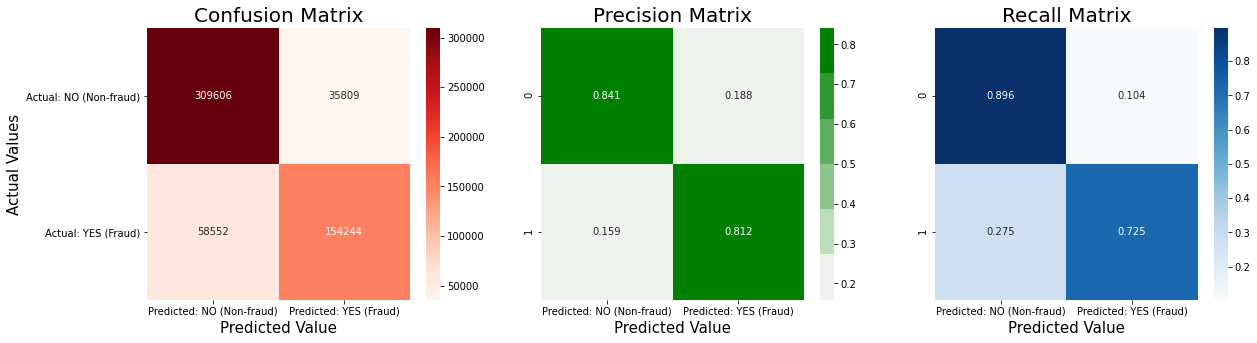

Percentage of misclassified points:  16.90418139377404 %
Sum of columns in the Precision Matrix:  [1. 1.]
Sum of rows in the Recall Matrix:  [1. 1.]
False Positive Rate (FPR):  0.10366949900843912
False Negative Rate (FNR):  0.27515554803661724
Balanced Accuracy Score (BACC):  0.8105874764774719
Matthew's Correlation Coefficient (MCC):  0.6366661744704736


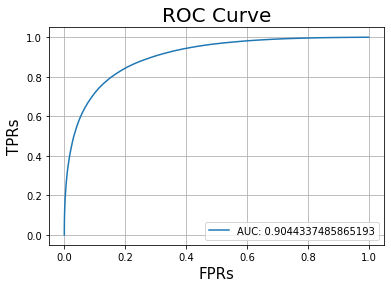

Wall time: 3min 5s


In [13]:
%%time
function2(X=xTrain, y=yTrain)

----